In [1]:
import numpy as np
import networkx as nx

from matching.glema.common.model import InferenceGNN
import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.misc.cpg_const as cpg_const

In [2]:
args = arg_utils.parse_args( use_default=True )

args.dataset = "CPG_augm"
args.directed = False
args.anchored = True
version = model_utils.get_latest_model_version( args )

args = arg_utils.load_args( args, version=version )
args.iso = True
args.test_data = True

In [3]:
model = InferenceGNN( args )

Loading model from /Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/training/save/CPG_augm_undirected_anchored_v1/model.pt ...


In [4]:
def predict( model, G_source, G_query ) -> float:
    results = model.predict_label( [ G_query ], [ G_source ] )
    return results[ 0 ].item()

def is_subgraph( model: InferenceGNN, G_source, G_query, conf=0.5 ) -> bool:
    prediction = predict( model, G_source, G_query )
    print( f"query is subgraph of source: {prediction > conf} [{prediction:.3}]" )
    return prediction > conf

In [5]:
record_scopes = graph_utils.get_record_scopes( args )
design_patterns = graph_utils.get_design_patterns( args )
label_args = {
    "record_scopes": record_scopes,
    "design_patterns": design_patterns
}

In [6]:
source_graph_idx = 0
query_subgraph_idx = 8

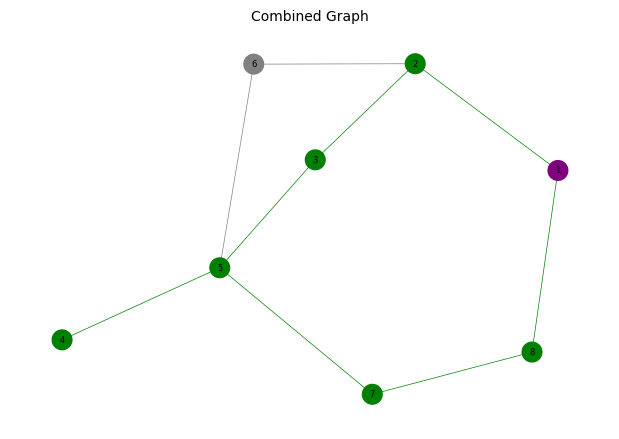

In [7]:
source = graph_utils.load_source_graph( args, source_graph_idx )
query = graph_utils.load_query_graph( args, source_graph_idx, query_subgraph_idx )
matching_colors = {
    2: "purple",
    1: "green",
    0: "grey",
    -1: "red"
}
combined, node_colors, edge_colors = graph_utils.combine_graph( source, query,
                                                          matching_colors=matching_colors )
plot_utils.plot_graph(
    title="Combined Graph",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors,
    #nodeLabels=graph_utils.get_node_labels( combined, **label_args )
)

In [8]:
is_subgraph( model, source, query )

query is subgraph of source: True [0.796]


True

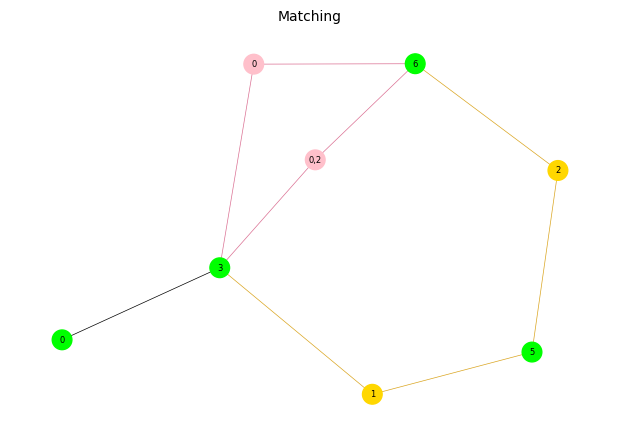

In [9]:
graph_utils.plot_interactions( args, model, source_graph_idx, query_subgraph_idx )

In [10]:
def addCpgNode( G, label : cpg_const.NodeLabel, anchor=False ):
    node_id = G.number_of_nodes()
    anchor_idx = 1 if anchor else 0
    G.add_node( node_id, label=misc_utils.get_enum_idx( label ), anchor=anchor_idx )
    return node_id

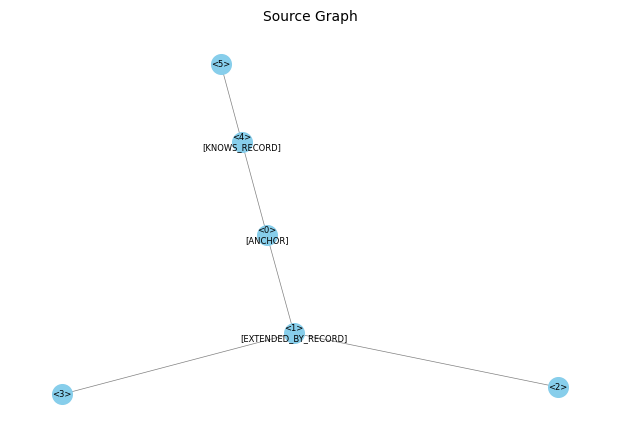

In [11]:
test_source = nx.DiGraph() if args.directed else nx.Graph()
node_a = addCpgNode( test_source, cpg_const.NodeLabel.RECORD, anchor=True )
node_b = addCpgNode( test_source, cpg_const.NodeLabel.EXTENDED_BY_RECORD )
node_c = addCpgNode( test_source, cpg_const.NodeLabel.RECORD )
node_d = addCpgNode( test_source, cpg_const.NodeLabel.RECORD )
node_e = addCpgNode( test_source, cpg_const.NodeLabel.KNOWS_RECORD )
node_f = addCpgNode( test_source, cpg_const.NodeLabel.RECORD )
test_source.add_edge( node_a, node_b )
test_source.add_edge( node_b, node_c )
test_source.add_edge( node_b, node_d )
test_source.add_edge( node_f, node_e )
test_source.add_edge( node_e, node_a )

plot_utils.plot_graph( test_source,
                  title="Source Graph",
                  nodeLabels=graph_utils.get_node_labels( test_source ) )

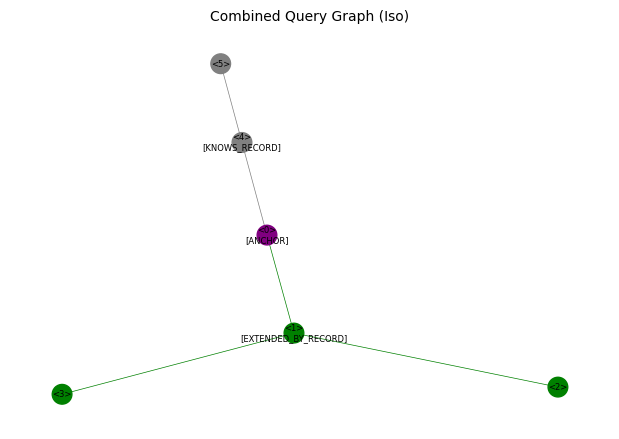

query is subgraph of source: True [0.769]


True

In [12]:
test_query_iso = test_source.copy()
test_query_iso.remove_node( node_e )
test_query_iso.remove_node( node_f )

combined, node_colors, edge_colors = graph_utils.combine_graph( test_source, test_query_iso,
                                                          matching_colors=matching_colors )
plot_utils.plot_graph(
    title="Combined Query Graph (Iso)",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors,
    nodeLabels=graph_utils.get_node_labels( combined )
)
is_subgraph( model, test_source, test_query_iso )

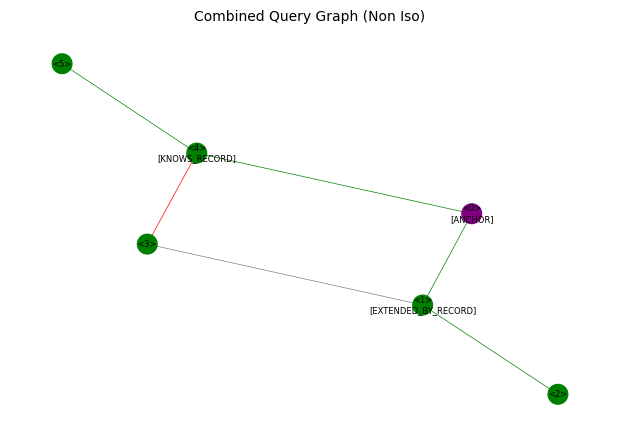

query is subgraph of source: False [0.458]


False

In [13]:
test_query_non_iso = test_source.copy()
test_query_non_iso.remove_edge( node_b, node_d )
test_query_non_iso.add_edge( node_e, node_d )

combined, node_colors, edge_colors = graph_utils.combine_graph( test_source, test_query_non_iso,
                                                          matching_colors=matching_colors )
plot_utils.plot_graph(
    title="Combined Query Graph (Non Iso)",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors,
    nodeLabels=graph_utils.get_node_labels( combined )
)
is_subgraph( model, test_source, test_query_non_iso )

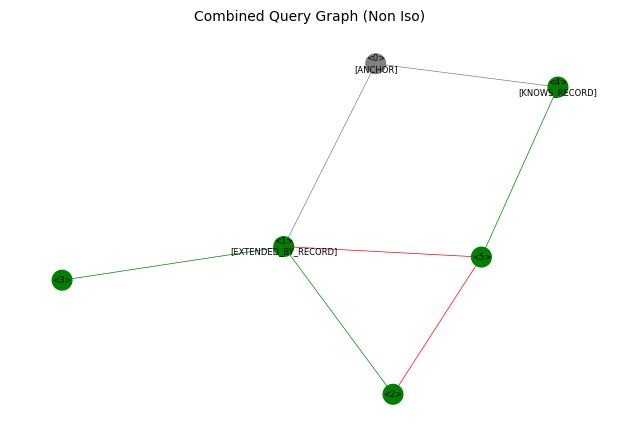

query is subgraph of source: True [0.621]


True

In [14]:
test_query_non_iso = test_source.copy()
test_query_non_iso.remove_node( node_a )
test_query_non_iso.nodes[ node_b ][ "anchored" ] = 1
test_query_non_iso.add_edge( node_f, node_b )
test_query_non_iso.add_edge( node_f, node_c )

combined, node_colors, edge_colors = graph_utils.combine_graph( test_source, test_query_non_iso,
                                                          matching_colors=matching_colors )
plot_utils.plot_graph(
    title="Combined Query Graph (Non Iso)",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors,
    nodeLabels=graph_utils.get_node_labels( combined )
)
is_subgraph( model, test_source, test_query_non_iso )

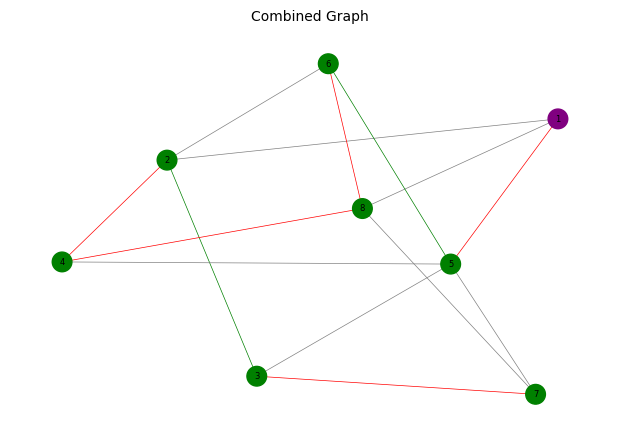

query is subgraph of source: True [0.735]


True

In [15]:
args.test_data = True
args.iso = False
source_graph_idx = 0
query_subgraph_idx = 6
source = graph_utils.load_source_graph( args, source_graph_idx )
query = graph_utils.load_query_graph( args, source_graph_idx, query_subgraph_idx )
combined, node_colors, edge_colors = graph_utils.combine_graph( source, query,
                                                                matching_colors=matching_colors )
plot_utils.plot_graph(
    title="Combined Graph",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors
)
is_subgraph( model, source, query )

In [16]:
args.test_data = True
args.iso = False
source_graph_idx = 0
source = graph_utils.load_source_graph( args, source_graph_idx )
queries = graph_utils.load_query_graphs( args, source_graph_idx )

total_subs = 0
for query_graph_idx, query in queries.items():
    is_sub = is_subgraph( model, source, query )
    if is_sub:
        total_subs += 1

total_subs / len( queries )

query is subgraph of source: False [0.355]
query is subgraph of source: False [0.355]
query is subgraph of source: False [0.381]
query is subgraph of source: True [0.612]
query is subgraph of source: False [0.302]
query is subgraph of source: False [0.308]
query is subgraph of source: True [0.735]
query is subgraph of source: False [0.427]
query is subgraph of source: False [0.456]
query is subgraph of source: False [0.347]
query is subgraph of source: False [0.475]
query is subgraph of source: False [0.43]
query is subgraph of source: True [0.555]
query is subgraph of source: True [0.717]
query is subgraph of source: False [0.288]
query is subgraph of source: True [0.539]
query is subgraph of source: False [0.455]
query is subgraph of source: False [0.339]
query is subgraph of source: False [0.427]
query is subgraph of source: False [0.329]
query is subgraph of source: False [0.448]
query is subgraph of source: False [0.427]
query is subgraph of source: False [0.342]
query is subgraph

0.1935483870967742